# Code Quality Analysis Dashboard

This notebook runs various code quality tools on the backend/ directory and visualizes the results:

- **Bandit**: Security vulnerability scanner
- **Ruff**: Fast Python linter
- **MyPy**: Static type checker
- **Radon CC**: Cyclomatic complexity analyzer
- **Radon MI**: Maintainability index calculator
- **Flake8 WPS**: Wemake Python Styleguide checker
- **Vulture**: Dead code detector

## Metrics to Analyze:
1. Error counts by tool and severity
2. Error type distribution
3. Code complexity metrics
4. Maintainability scores
5. Security vulnerability patterns
6. Dead code detection

## Import Required Libraries

In [1]:
import json
import re
import subprocess
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Set up plotting style with high-resolution settings
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# High-resolution plot configuration
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150  # High DPI for crisp plots
plt.rcParams["savefig.dpi"] = 300  # High DPI for saved figures
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["patch.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 1.2
plt.rcParams["ytick.major.width"] = 1.2
plt.rcParams["xtick.minor.width"] = 0.8
plt.rcParams["ytick.minor.width"] = 0.8
plt.rcParams["text.antialiased"] = True
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

print("Libraries imported successfully with high-resolution plotting configuration!")

Libraries imported successfully with high-resolution plotting configuration!


## Define Code Quality Tools and Commands

In [2]:
# Define the backend directory path
BACKEND_DIR = "backend/"

# Define commands for each tool
TOOLS_COMMANDS = {
    "bandit": ["bandit", "-c", "pyproject.toml", "-r", BACKEND_DIR, "-f", "json"],
    "ruff": ["ruff", "check", BACKEND_DIR, "--output-format", "json"],
    "mypy": ["mypy", BACKEND_DIR],
    "radon_cc": ["radon", "cc", BACKEND_DIR, "-j"],
    "radon_mi": ["radon", "mi", BACKEND_DIR, "-j"],
    "flake8_wps": ["flake8", "--select=WPS", BACKEND_DIR, "--format=json"],
    "vulture": ["vulture", BACKEND_DIR],
}

print(f"Analyzing directory: {Path(BACKEND_DIR).absolute()}")
print("Tools configured:")
for tool, cmd in TOOLS_COMMANDS.items():
    print(f"  - {tool}: {' '.join(cmd)}")

Analyzing directory: /Users/somen/Zavodi/opensource/fastapi-moscow-python-demo-1/backend
Tools configured:
  - bandit: bandit -c pyproject.toml -r backend/ -f json
  - ruff: ruff check backend/ --output-format json
  - mypy: mypy backend/
  - radon_cc: radon cc backend/ -j
  - radon_mi: radon mi backend/ -j
  - flake8_wps: flake8 --select=WPS backend/ --format=json
  - vulture: vulture backend/


## Run Bandit Security Analysis

In [3]:
def run_bandit():
    """Run bandit security analysis and return parsed results."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["bandit"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            bandit_data = json.loads(result.stdout)
            issues = bandit_data.get("results", [])

            bandit_df = pd.DataFrame(
                [
                    {
                        "tool": "bandit",
                        "file": issue["filename"],
                        "line": issue["line_number"],
                        "severity": issue["issue_severity"],
                        "confidence": issue["issue_confidence"],
                        "test_id": issue["test_id"],
                        "test_name": issue["test_name"],
                        "message": issue["issue_text"],
                    }
                    for issue in issues
                ]
            )

            print(f"Bandit found {len(bandit_df)} security issues")
            return bandit_df
        print("Bandit: No issues found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running bandit: {e}")
        return pd.DataFrame()


bandit_results = run_bandit()
if not bandit_results.empty:
    print("\nBandit Results Summary:")
    print(bandit_results.groupby(["severity", "confidence"]).size())

Bandit found 2 security issues

Bandit Results Summary:
severity  confidence
LOW       MEDIUM        2
dtype: int64


## Run Ruff Linting

In [4]:
def run_ruff():
    """Run ruff linter and return parsed results."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["ruff"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            ruff_data = json.loads(result.stdout)

            ruff_df = pd.DataFrame(
                [
                    {
                        "tool": "ruff",
                        "file": issue["filename"],
                        "line": issue["location"]["row"],
                        "column": issue["location"]["column"],
                        "rule_code": issue["code"],
                        "rule_name": issue["message"],
                        "message": issue["message"],
                        "severity": "error" if issue.get("fix") else "warning",
                    }
                    for issue in ruff_data
                ]
            )

            print(f"Ruff found {len(ruff_df)} linting issues")
            return ruff_df
        print("Ruff: No issues found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running ruff: {e}")
        return pd.DataFrame()


ruff_results = run_ruff()
if not ruff_results.empty:
    print("\nRuff Results Summary:")
    print("Top 10 most common rules:")
    print(ruff_results["rule_code"].value_counts().head(10))

Ruff found 8 linting issues

Ruff Results Summary:
Top 10 most common rules:
rule_code
E501    4
D103    2
D400    1
D415    1
Name: count, dtype: int64


## Run MyPy Type Checking

In [5]:
def run_mypy():
    """Run mypy type checker and return parsed results."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["mypy"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            lines = result.stdout.strip().split("\n")
            mypy_issues = []

            for line in lines:
                if ":" in line and (
                    "error:" in line or "warning:" in line or "note:" in line
                ):
                    parts = line.split(":")
                    if len(parts) >= 4:
                        file_path = parts[0]
                        line_num = parts[1] if parts[1].isdigit() else "0"
                        severity = (
                            "error"
                            if "error:" in line
                            else "warning"
                            if "warning:" in line
                            else "note"
                        )
                        message = ":".join(parts[3:]).strip()

                        mypy_issues.append(
                            {
                                "tool": "mypy",
                                "file": file_path,
                                "line": int(line_num),
                                "severity": severity,
                                "message": message,
                            }
                        )

            mypy_df = pd.DataFrame(mypy_issues)
            print(f"MyPy found {len(mypy_df)} type checking issues")
            return mypy_df
        print("MyPy: No issues found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running mypy: {e}")
        return pd.DataFrame()


mypy_results = run_mypy()
if not mypy_results.empty:
    print("\nMyPy Results Summary:")
    print(mypy_results["severity"].value_counts())

MyPy found 7 type checking issues

MyPy Results Summary:
severity
error    5
note     2
Name: count, dtype: int64


## Run Radon Cyclomatic Complexity Analysis

In [6]:
def run_radon_cc():
    """Run radon cyclomatic complexity analysis and return parsed results (all ranks)."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["radon_cc"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            cc_data = json.loads(result.stdout)
            cc_issues = []

            for file_path, functions in cc_data.items():
                for func in functions:
                    cc_issues.append(
                        {
                            "tool": "radon_cc",
                            "file": file_path,
                            "function": func["name"],
                            "line": func["lineno"],
                            "complexity": func["complexity"],
                            "rank": func["rank"],
                            "type": func["type"],
                        }
                    )

            cc_df = pd.DataFrame(cc_issues)
            print(
                f"Radon CC analyzed {len(cc_df)} functions/methods (all ranks included)"
            )
            return cc_df
        print("Radon CC: No data found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running radon cc: {e}")
        return pd.DataFrame()


radon_cc_results = run_radon_cc()
if not radon_cc_results.empty:
    print("\nRadon CC Results Summary:")
    print(f"Average complexity: {radon_cc_results['complexity'].mean():.2f}")
    print("Complexity rank distribution:")
    print(radon_cc_results["rank"].value_counts().sort_index())

Radon CC analyzed 180 functions/methods (all ranks included)

Radon CC Results Summary:
Average complexity: 2.27
Complexity rank distribution:
rank
A    173
B      7
Name: count, dtype: int64


## Run Radon Maintainability Index Analysis

In [7]:
def run_radon_mi():
    """Run radon maintainability index analysis and return parsed results (all ranks)."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["radon_mi"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            mi_data = json.loads(result.stdout)
            mi_issues = []

            for file_path, mi_info in mi_data.items():
                mi_issues.append(
                    {
                        "tool": "radon_mi",
                        "file": file_path,
                        "mi_score": mi_info["mi"],
                        "mi_rank": mi_info["rank"],
                    }
                )

            mi_df = pd.DataFrame(mi_issues)
            print(f"Radon MI analyzed {len(mi_df)} files (all ranks included)")
            return mi_df
        print("Radon MI: No data found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running radon mi: {e}")
        return pd.DataFrame()


radon_mi_results = run_radon_mi()
if not radon_mi_results.empty:
    print("\nRadon MI Results Summary:")
    print(f"Average maintainability index: {radon_mi_results['mi_score'].mean():.2f}")
    print("MI rank distribution:")
    print(radon_mi_results["mi_rank"].value_counts().sort_index())

Radon MI analyzed 57 files (all ranks included)

Radon MI Results Summary:
Average maintainability index: 80.63
MI rank distribution:
mi_rank
A    57
Name: count, dtype: int64


## Run Flake8 with WPS Plugin

In [8]:
def run_flake8_wps():
    """Run flake8 with WPS plugin and return parsed results."""
    try:
        # Try with regular flake8 output format since json might not be available
        result = subprocess.run(
            ["flake8", "--select=WPS", BACKEND_DIR],
            check=False, capture_output=True,
            text=True,
            cwd=Path.cwd(),
        )

        if result.stdout:
            lines = result.stdout.strip().split("\n")
            flake8_issues = []

            for line in lines:
                if line.strip():
                    # Parse flake8 output format: file:line:column: code message
                    parts = line.split(":")
                    if len(parts) >= 4:
                        file_path = parts[0]
                        line_num = parts[1] if parts[1].isdigit() else "0"
                        column = parts[2] if parts[2].isdigit() else "0"

                        # Extract error code and message
                        error_part = ":".join(parts[3:]).strip()
                        error_match = re.match(r"\s*(WPS\d+)\s+(.+)", error_part)
                        if error_match:
                            error_code = error_match.group(1)
                            message = error_match.group(2)

                            flake8_issues.append(
                                {
                                    "tool": "flake8_wps",
                                    "file": file_path,
                                    "line": int(line_num),
                                    "column": int(column),
                                    "rule_code": error_code,
                                    "message": message,
                                    "severity": "warning",
                                }
                            )

            flake8_df = pd.DataFrame(flake8_issues)
            print(f"Flake8 WPS found {len(flake8_df)} style issues")
            return flake8_df
        print("Flake8 WPS: No issues found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running flake8 WPS: {e}")
        print("Note: Make sure wemake-python-styleguide is installed")
        return pd.DataFrame()


flake8_wps_results = run_flake8_wps()
if not flake8_wps_results.empty:
    print("\nFlake8 WPS Results Summary:")
    print("Top 10 most common WPS rules:")
    print(flake8_wps_results["rule_code"].value_counts().head(10))

Flake8 WPS found 16 style issues

Flake8 WPS Results Summary:
Top 10 most common WPS rules:
rule_code
WPS226    4
WPS432    2
WPS110    2
WPS235    1
WPS407    1
WPS221    1
WPS238    1
WPS210    1
WPS231    1
WPS237    1
Name: count, dtype: int64


## Run Vulture Dead Code Analysis

In [9]:
def run_vulture():
    """Run vulture dead code detector and return parsed results."""
    try:
        result = subprocess.run(
            TOOLS_COMMANDS["vulture"], check=False, capture_output=True, text=True, cwd=Path.cwd()
        )

        if result.stdout:
            lines = result.stdout.strip().split("\n")
            vulture_issues = []

            for line in lines:
                if line.strip():
                    # Parse vulture output format: file:line: message (confidence %)
                    parts = line.split(":")
                    if len(parts) >= 3:
                        file_path = parts[0]
                        line_num = parts[1] if parts[1].isdigit() else "0"
                        message_part = ":".join(parts[2:]).strip()

                        # Extract confidence percentage if present
                        confidence_match = re.search(
                            r"\((\d+)% confidence\)", message_part
                        )
                        confidence = (
                            int(confidence_match.group(1)) if confidence_match else 100
                        )

                        # Extract dead code type
                        dead_code_type = "unknown"
                        if "unused function" in message_part.lower():
                            dead_code_type = "function"
                        elif "unused variable" in message_part.lower():
                            dead_code_type = "variable"
                        elif "unused import" in message_part.lower():
                            dead_code_type = "import"
                        elif "unused class" in message_part.lower():
                            dead_code_type = "class"
                        elif "unused attribute" in message_part.lower():
                            dead_code_type = "attribute"

                        vulture_issues.append(
                            {
                                "tool": "vulture",
                                "file": file_path,
                                "line": int(line_num),
                                "message": message_part,
                                "confidence": confidence,
                                "dead_code_type": dead_code_type,
                                "severity": "warning",
                            }
                        )

            vulture_df = pd.DataFrame(vulture_issues)
            print(f"Vulture found {len(vulture_df)} dead code issues")
            return vulture_df
        print("Vulture: No dead code found")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error running vulture: {e}")
        print("Note: Make sure vulture is installed (pip install vulture)")
        return pd.DataFrame()


vulture_results = run_vulture()
if not vulture_results.empty:
    print("\nVulture Results Summary:")
    print("Dead code types found:")
    print(vulture_results["dead_code_type"].value_counts())
    print(f"Average confidence: {vulture_results['confidence'].mean():.1f}%")

Vulture found 8 dead code issues

Vulture Results Summary:
Dead code types found:
dead_code_type
variable    8
Name: count, dtype: int64
Average confidence: 60.0%


## Parse and Aggregate Results

In [10]:
# Aggregate all results for visualization
all_results = {
    "bandit": bandit_results,
    "ruff": ruff_results,
    "mypy": mypy_results,
    "radon_cc": radon_cc_results,
    "radon_mi": radon_mi_results,
    "flake8_wps": flake8_wps_results,
    "vulture": vulture_results,
}

# Prepare filtered copies for issue counting (exclude non-issues: rank A for radon metrics)
issue_results = {}
for tool, df in all_results.items():
    if df is None or df.empty:
        issue_results[tool] = df
        continue
    if tool == "radon_cc":
        issue_results[tool] = df[df["rank"] != "A"]  # exclude excellent complexity
    elif tool == "radon_mi":
        issue_results[tool] = df[
            df["mi_rank"] != "A"
        ]  # exclude excellent maintainability
    else:
        issue_results[tool] = df

# Calculate summary statistics using issue_results
summary_stats = {}
for tool, df in issue_results.items():
    summary_stats[tool] = {
        "total_issues": len(df) if df is not None else 0,
        "files_analyzed": df["file"].nunique()
        if df is not None and not df.empty and "file" in df.columns
        else 0,
    }

print("\n=== SUMMARY STATISTICS (Radon A ranks excluded from counts) ===")
summary_df = pd.DataFrame(summary_stats).T
print(summary_df)

# Create a combined issues dataframe for common fields (using issue_results)
issue_dfs = []
for tool, df in issue_results.items():
    if df is not None and not df.empty and "file" in df.columns:
        issue_df = df[["tool", "file"]].copy()
        if "line" in df.columns:
            issue_df["line"] = df["line"]
        if "severity" in df.columns:
            issue_df["severity"] = df["severity"]
        elif tool == "radon_cc" and "rank" in df.columns:
            issue_df["severity"] = df["rank"]
        elif tool == "radon_mi" and "mi_rank" in df.columns:
            issue_df["severity"] = df["mi_rank"]
        else:
            issue_df["severity"] = "info"
        issue_dfs.append(issue_df)

if issue_dfs:
    combined_issues = pd.concat(issue_dfs, ignore_index=True)
    print(f"\nTotal combined issues (excluding Radon A ranks): {len(combined_issues)}")
else:
    combined_issues = pd.DataFrame()
    print("\nNo issues found to analyze")


=== SUMMARY STATISTICS (Radon A ranks excluded from counts) ===
            total_issues  files_analyzed
bandit                 2               2
ruff                   8               2
mypy                   7               2
radon_cc               7               4
radon_mi               0               0
flake8_wps            16               2
vulture                8               3

Total combined issues (excluding Radon A ranks): 48


## Create Error Count Visualizations

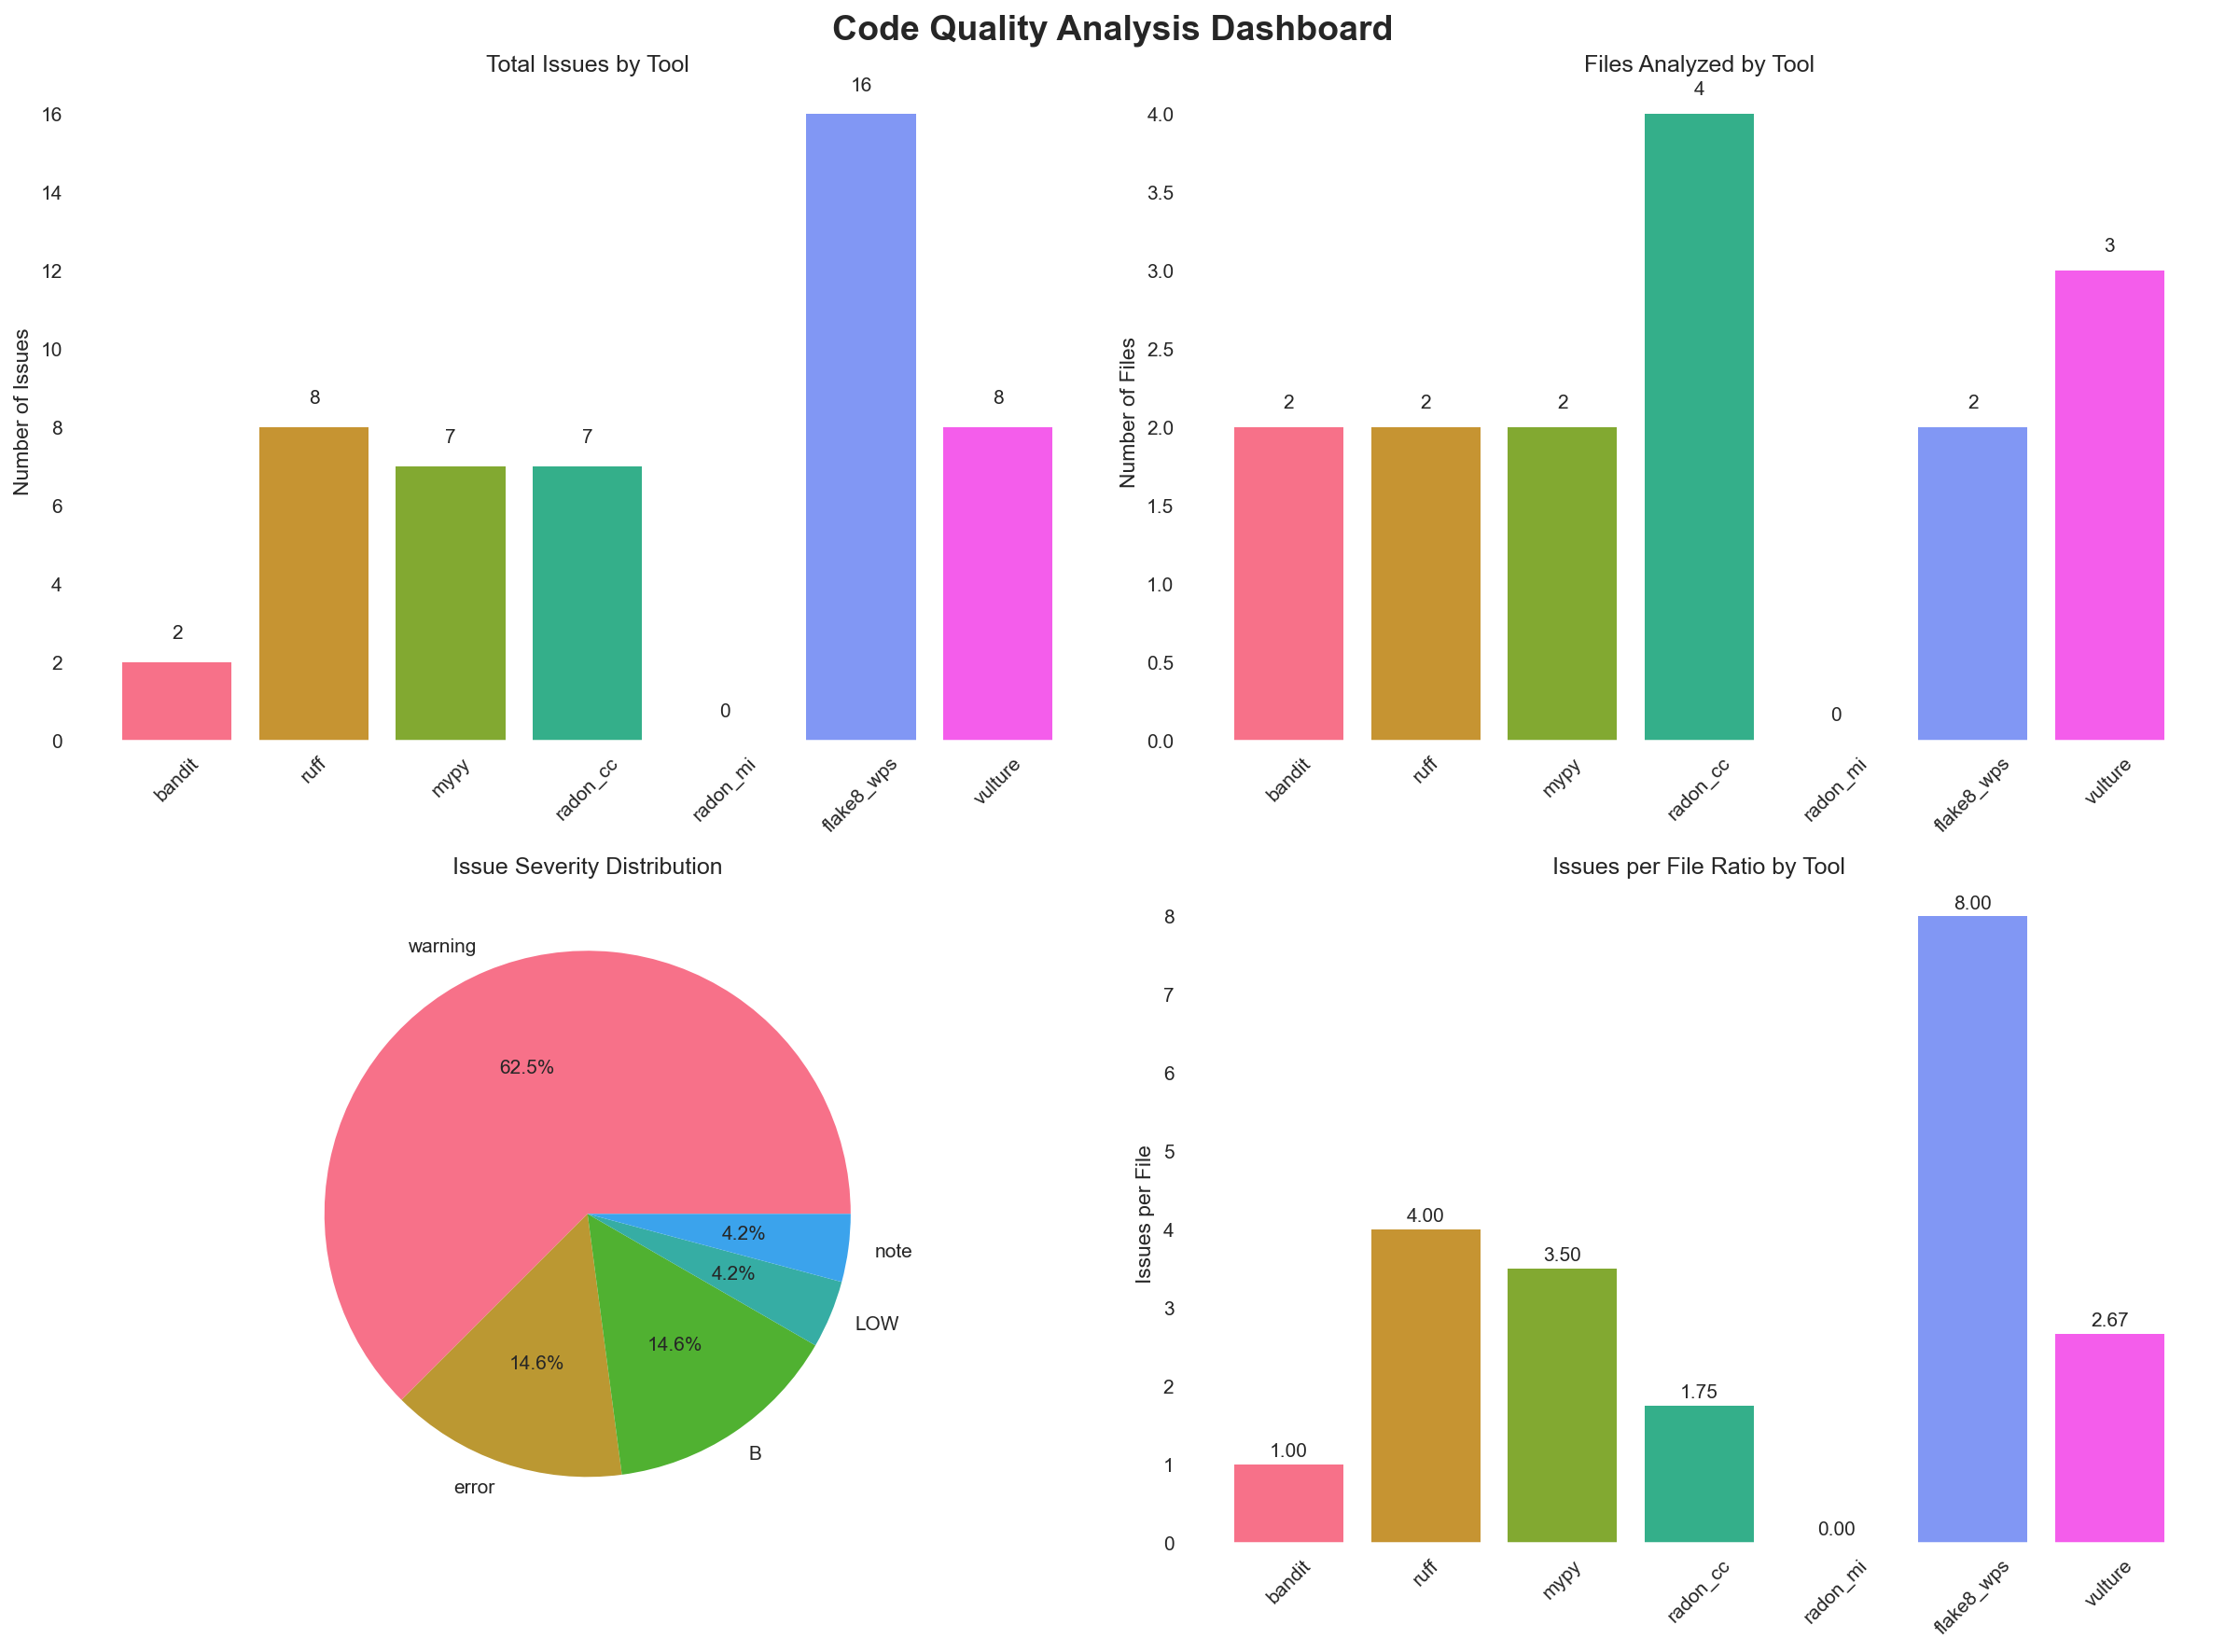

In [11]:
# Create visualizations with high-resolution settings
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=150)
fig.suptitle("Code Quality Analysis Dashboard", fontsize=18, fontweight="bold", y=0.98)

# 1. Total issues by tool
tools = list(summary_stats.keys())
issue_counts = [summary_stats[tool]["total_issues"] for tool in tools]

axes[0, 0].bar(tools, issue_counts, color=sns.color_palette("husl", len(tools)))
axes[0, 0].set_title("Total Issues by Tool")
axes[0, 0].set_ylabel("Number of Issues")
axes[0, 0].tick_params(axis="x", rotation=45)

# Add value labels on bars
for i, v in enumerate(issue_counts):
    axes[0, 0].text(i, v + 0.5, str(v), ha="center", va="bottom")

# 2. Files analyzed by tool
files_analyzed = [summary_stats[tool]["files_analyzed"] for tool in tools]
axes[0, 1].bar(tools, files_analyzed, color=sns.color_palette("husl", len(tools)))
axes[0, 1].set_title("Files Analyzed by Tool")
axes[0, 1].set_ylabel("Number of Files")
axes[0, 1].tick_params(axis="x", rotation=45)

for i, v in enumerate(files_analyzed):
    axes[0, 1].text(i, v + 0.1, str(v), ha="center", va="bottom")

# 3. Severity distribution (if we have combined issues)
if not combined_issues.empty:
    severity_counts = combined_issues["severity"].value_counts()
    axes[1, 0].pie(
        severity_counts.values, labels=severity_counts.index, autopct="%1.1f%%"
    )
    axes[1, 0].set_title("Issue Severity Distribution")
else:
    axes[1, 0].text(
        0.5,
        0.5,
        "No severity data available",
        ha="center",
        va="center",
        transform=axes[1, 0].transAxes,
    )
    axes[1, 0].set_title("Issue Severity Distribution")

# 4. Tool comparison - Issues vs Files ratio
if tools and any(files_analyzed):
    ratios = [issue_counts[i] / max(files_analyzed[i], 1) for i in range(len(tools))]
    axes[1, 1].bar(tools, ratios, color=sns.color_palette("husl", len(tools)))
    axes[1, 1].set_title("Issues per File Ratio by Tool")
    axes[1, 1].set_ylabel("Issues per File")
    axes[1, 1].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for i, v in enumerate(ratios):
        axes[1, 1].text(i, v + 0.05, f"{v:.2f}", ha="center", va="bottom")
else:
    axes[1, 1].text(
        0.5,
        0.5,
        "No ratio data available",
        ha="center",
        va="center",
        transform=axes[1, 1].transAxes,
    )
    axes[1, 1].set_title("Issues per File Ratio by Tool")

plt.tight_layout()
plt.show()

## Create Error Type Distribution Charts

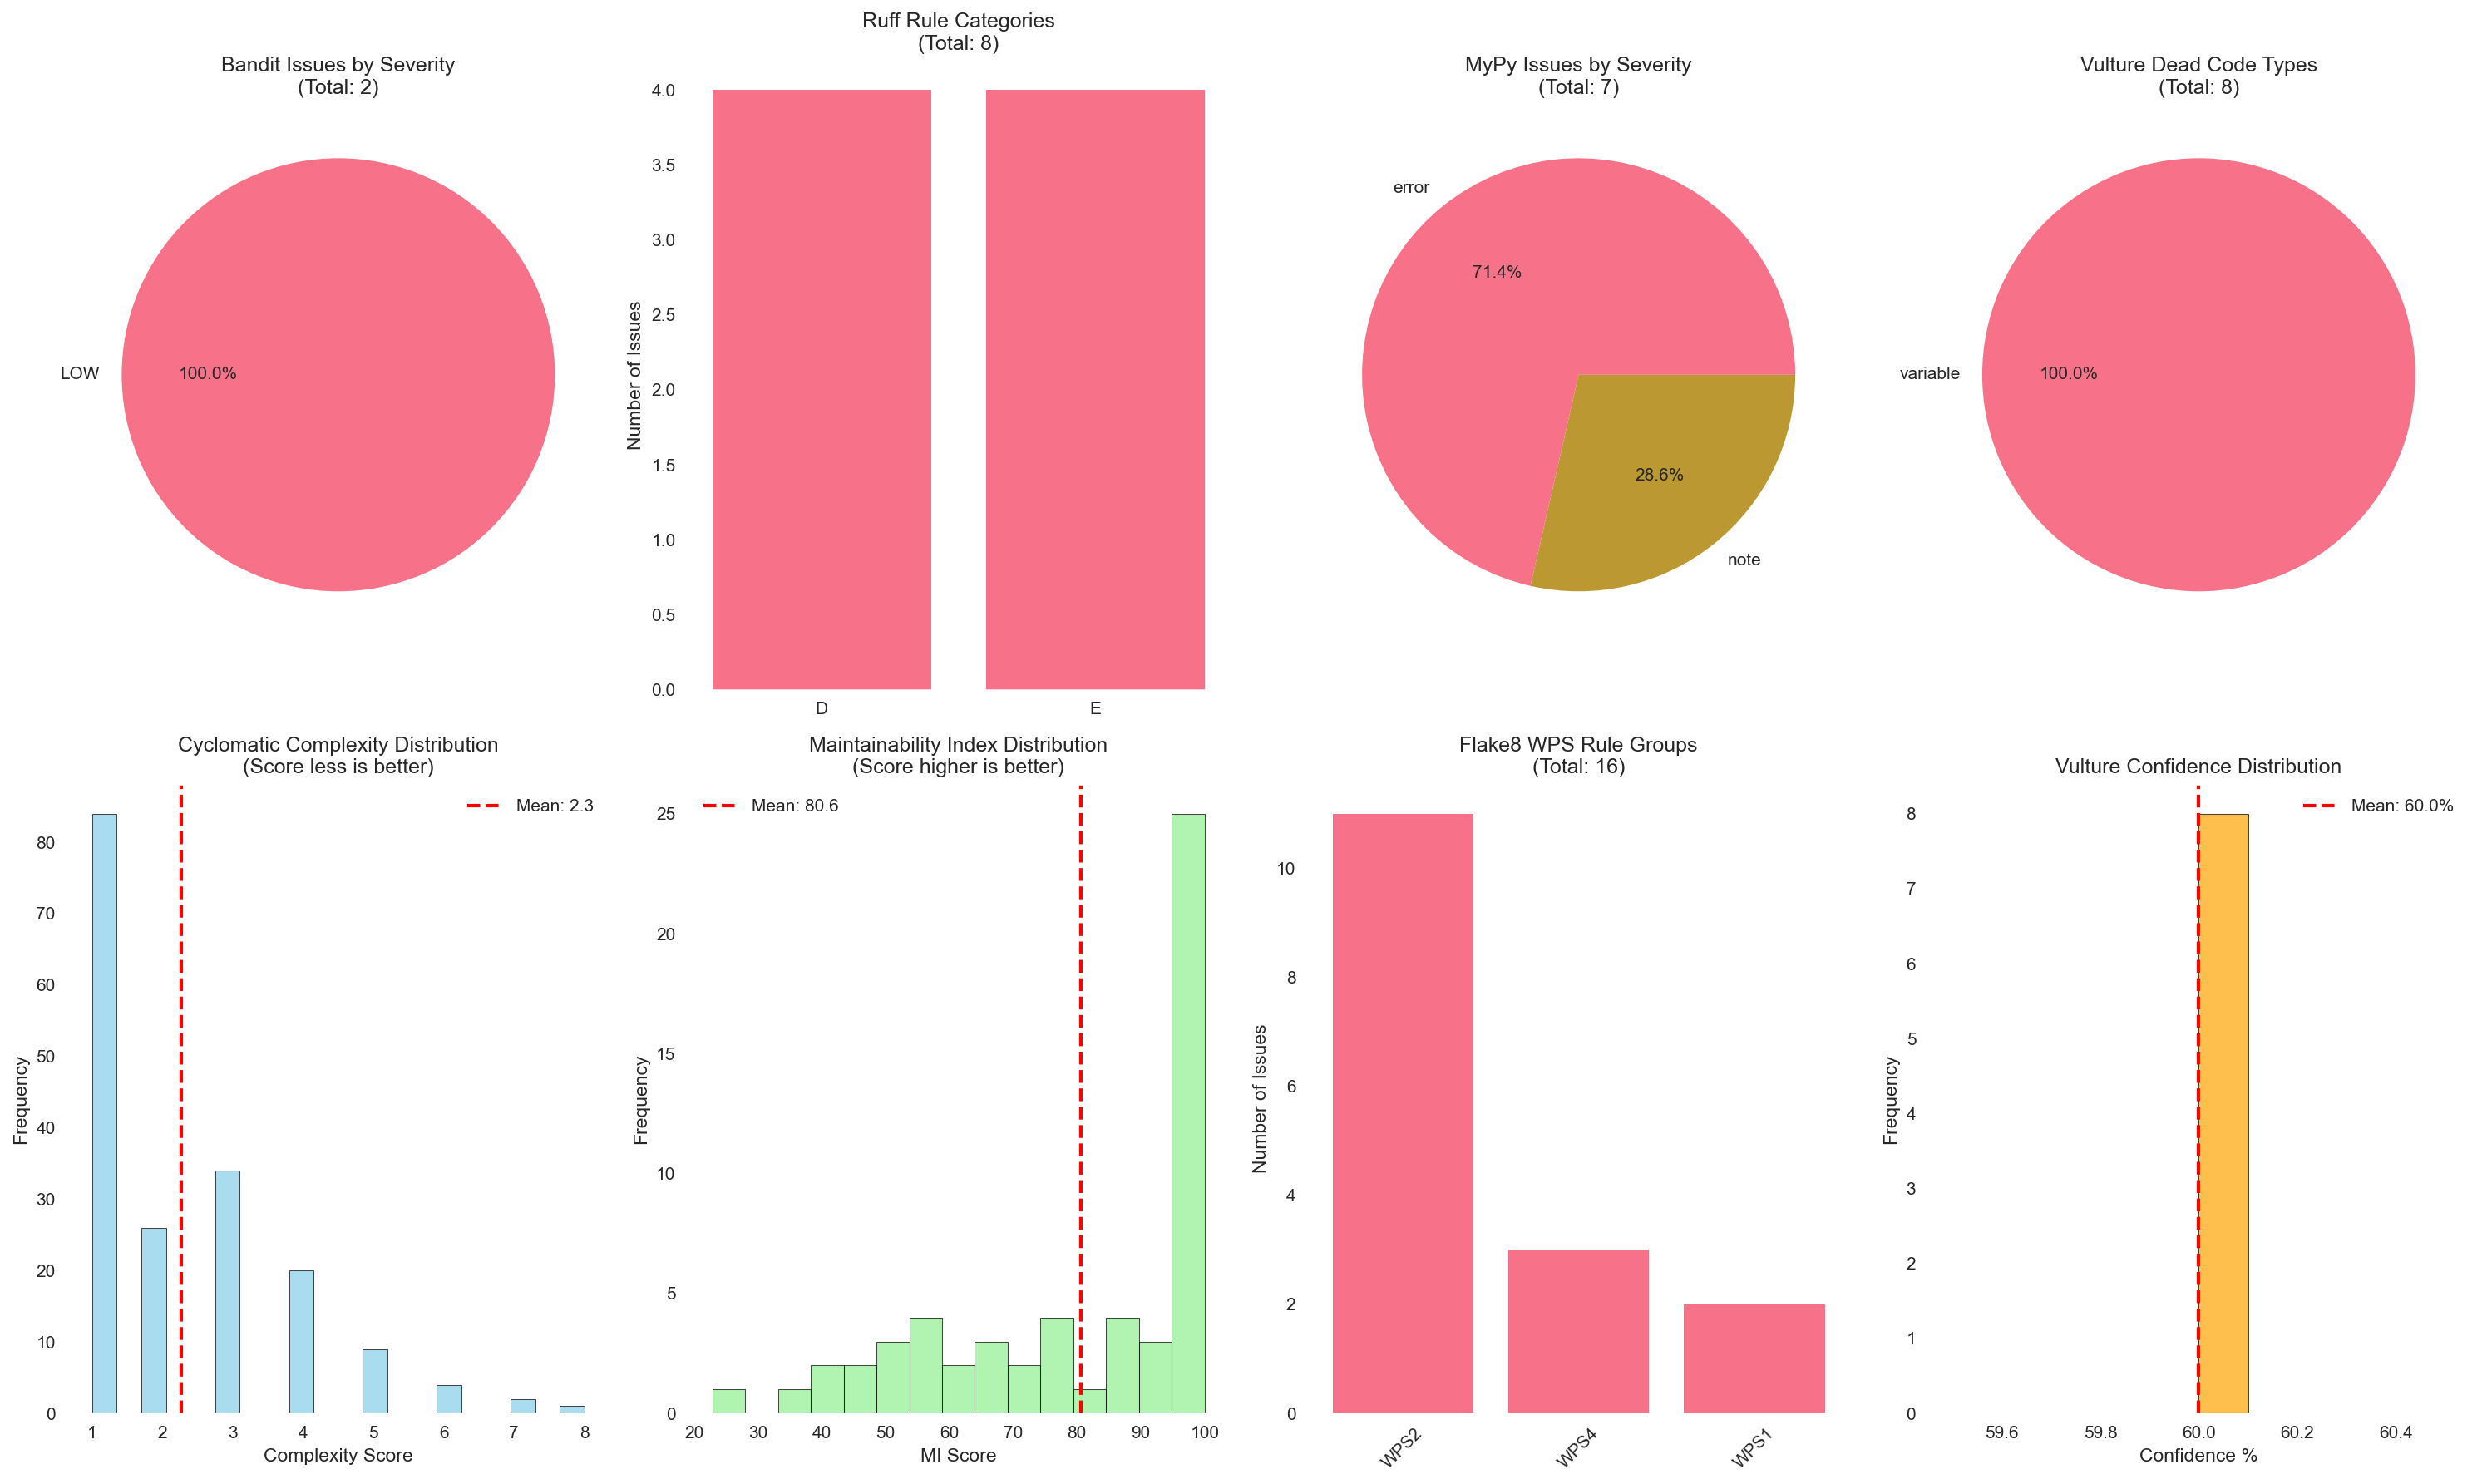

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 12), dpi=150)
# fig.suptitle('Error Type Distribution by Tool', fontsize=18, fontweight='bold', y=0.96)

# Bandit severity distribution
if not bandit_results.empty:
    bandit_severity = bandit_results["severity"].value_counts()
    axes[0, 0].pie(
        bandit_severity.values, labels=bandit_severity.index, autopct="%1.1f%%"
    )
    axes[0, 0].set_title(f"Bandit Issues by Severity\n(Total: {len(bandit_results)})")
else:
    axes[0, 0].text(
        0.5,
        0.5,
        "No Bandit issues",
        ha="center",
        va="center",
        transform=axes[0, 0].transAxes,
    )
    axes[0, 0].set_title("Bandit Issues by Severity")

# Ruff rule types
if not ruff_results.empty:
    # Extract rule categories (first letter of rule code)
    ruff_results["rule_category"] = ruff_results["rule_code"].str[0]
    ruff_categories = ruff_results["rule_category"].value_counts().head(8)
    axes[0, 1].bar(ruff_categories.index, ruff_categories.values)
    axes[0, 1].set_title(f"Ruff Rule Categories\n(Total: {len(ruff_results)})")
    axes[0, 1].set_ylabel("Number of Issues")
else:
    axes[0, 1].text(
        0.5,
        0.5,
        "No Ruff issues",
        ha="center",
        va="center",
        transform=axes[0, 1].transAxes,
    )
    axes[0, 1].set_title("Ruff Rule Categories")

# MyPy issue types
if not mypy_results.empty:
    mypy_severity = mypy_results["severity"].value_counts()
    axes[0, 2].pie(mypy_severity.values, labels=mypy_severity.index, autopct="%1.1f%%")
    axes[0, 2].set_title(f"MyPy Issues by Severity\n(Total: {len(mypy_results)})")
else:
    axes[0, 2].text(
        0.5,
        0.5,
        "No MyPy issues",
        ha="center",
        va="center",
        transform=axes[0, 2].transAxes,
    )
    axes[0, 2].set_title("MyPy Issues by Severity")

# Vulture dead code types
if not vulture_results.empty:
    vulture_types = vulture_results["dead_code_type"].value_counts()
    axes[0, 3].pie(vulture_types.values, labels=vulture_types.index, autopct="%1.1f%%")
    axes[0, 3].set_title(f"Vulture Dead Code Types\n(Total: {len(vulture_results)})")
else:
    axes[0, 3].text(
        0.5,
        0.5,
        "No dead code found",
        ha="center",
        va="center",
        transform=axes[0, 3].transAxes,
    )
    axes[0, 3].set_title("Vulture Dead Code Types")

# Radon CC complexity distribution
if not radon_cc_results.empty:
    axes[1, 0].hist(
        radon_cc_results["complexity"],
        bins=20,
        alpha=0.7,
        color="skyblue",
        edgecolor="black",
    )
    axes[1, 0].set_title("Cyclomatic Complexity Distribution\n(Score less is better)")
    axes[1, 0].set_xlabel("Complexity Score")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].axvline(
        radon_cc_results["complexity"].mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {radon_cc_results['complexity'].mean():.1f}",
    )
    axes[1, 0].legend()
else:
    axes[1, 0].text(
        0.5,
        0.5,
        "No complexity data",
        ha="center",
        va="center",
        transform=axes[1, 0].transAxes,
    )
    axes[1, 0].set_title("Cyclomatic Complexity Distribution")

# Radon MI maintainability distribution
if not radon_mi_results.empty:
    axes[1, 1].hist(
        radon_mi_results["mi_score"],
        bins=15,
        alpha=0.7,
        color="lightgreen",
        edgecolor="black",
    )
    axes[1, 1].set_title("Maintainability Index Distribution\n(Score higher is better)")
    axes[1, 1].set_xlabel("MI Score")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].axvline(
        radon_mi_results["mi_score"].mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {radon_mi_results['mi_score'].mean():.1f}",
    )
    axes[1, 1].legend()
else:
    axes[1, 1].text(
        0.5, 0.5, "No MI data", ha="center", va="center", transform=axes[1, 1].transAxes
    )
    axes[1, 1].set_title("Maintainability Index Distribution")

# Flake8 WPS rule types
if not flake8_wps_results.empty:
    # Group WPS rules by hundreds (WPS100, WPS200, etc.)
    flake8_wps_results["rule_group"] = flake8_wps_results["rule_code"].str.extract(
        r"(WPS\d{1})"
    )
    wps_groups = flake8_wps_results["rule_group"].value_counts().head(8)
    axes[1, 2].bar(wps_groups.index, wps_groups.values)
    axes[1, 2].set_title(f"Flake8 WPS Rule Groups\n(Total: {len(flake8_wps_results)})")
    axes[1, 2].set_ylabel("Number of Issues")
    axes[1, 2].tick_params(axis="x", rotation=45)
else:
    axes[1, 2].text(
        0.5,
        0.5,
        "No WPS issues",
        ha="center",
        va="center",
        transform=axes[1, 2].transAxes,
    )
    axes[1, 2].set_title("Flake8 WPS Rule Groups")

# Vulture confidence distribution
if not vulture_results.empty:
    axes[1, 3].hist(
        vulture_results["confidence"],
        bins=10,
        alpha=0.7,
        color="orange",
        edgecolor="black",
    )
    axes[1, 3].set_title("Vulture Confidence Distribution")
    axes[1, 3].set_xlabel("Confidence %")
    axes[1, 3].set_ylabel("Frequency")
    axes[1, 3].axvline(
        vulture_results["confidence"].mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {vulture_results['confidence'].mean():.1f}%",
    )
    axes[1, 3].legend()
else:
    axes[1, 3].text(
        0.5,
        0.5,
        "No confidence data",
        ha="center",
        va="center",
        transform=axes[1, 3].transAxes,
    )
    axes[1, 3].set_title("Vulture Confidence Distribution")

plt.tight_layout()
plt.show()

## Generate Complexity Metrics Plots

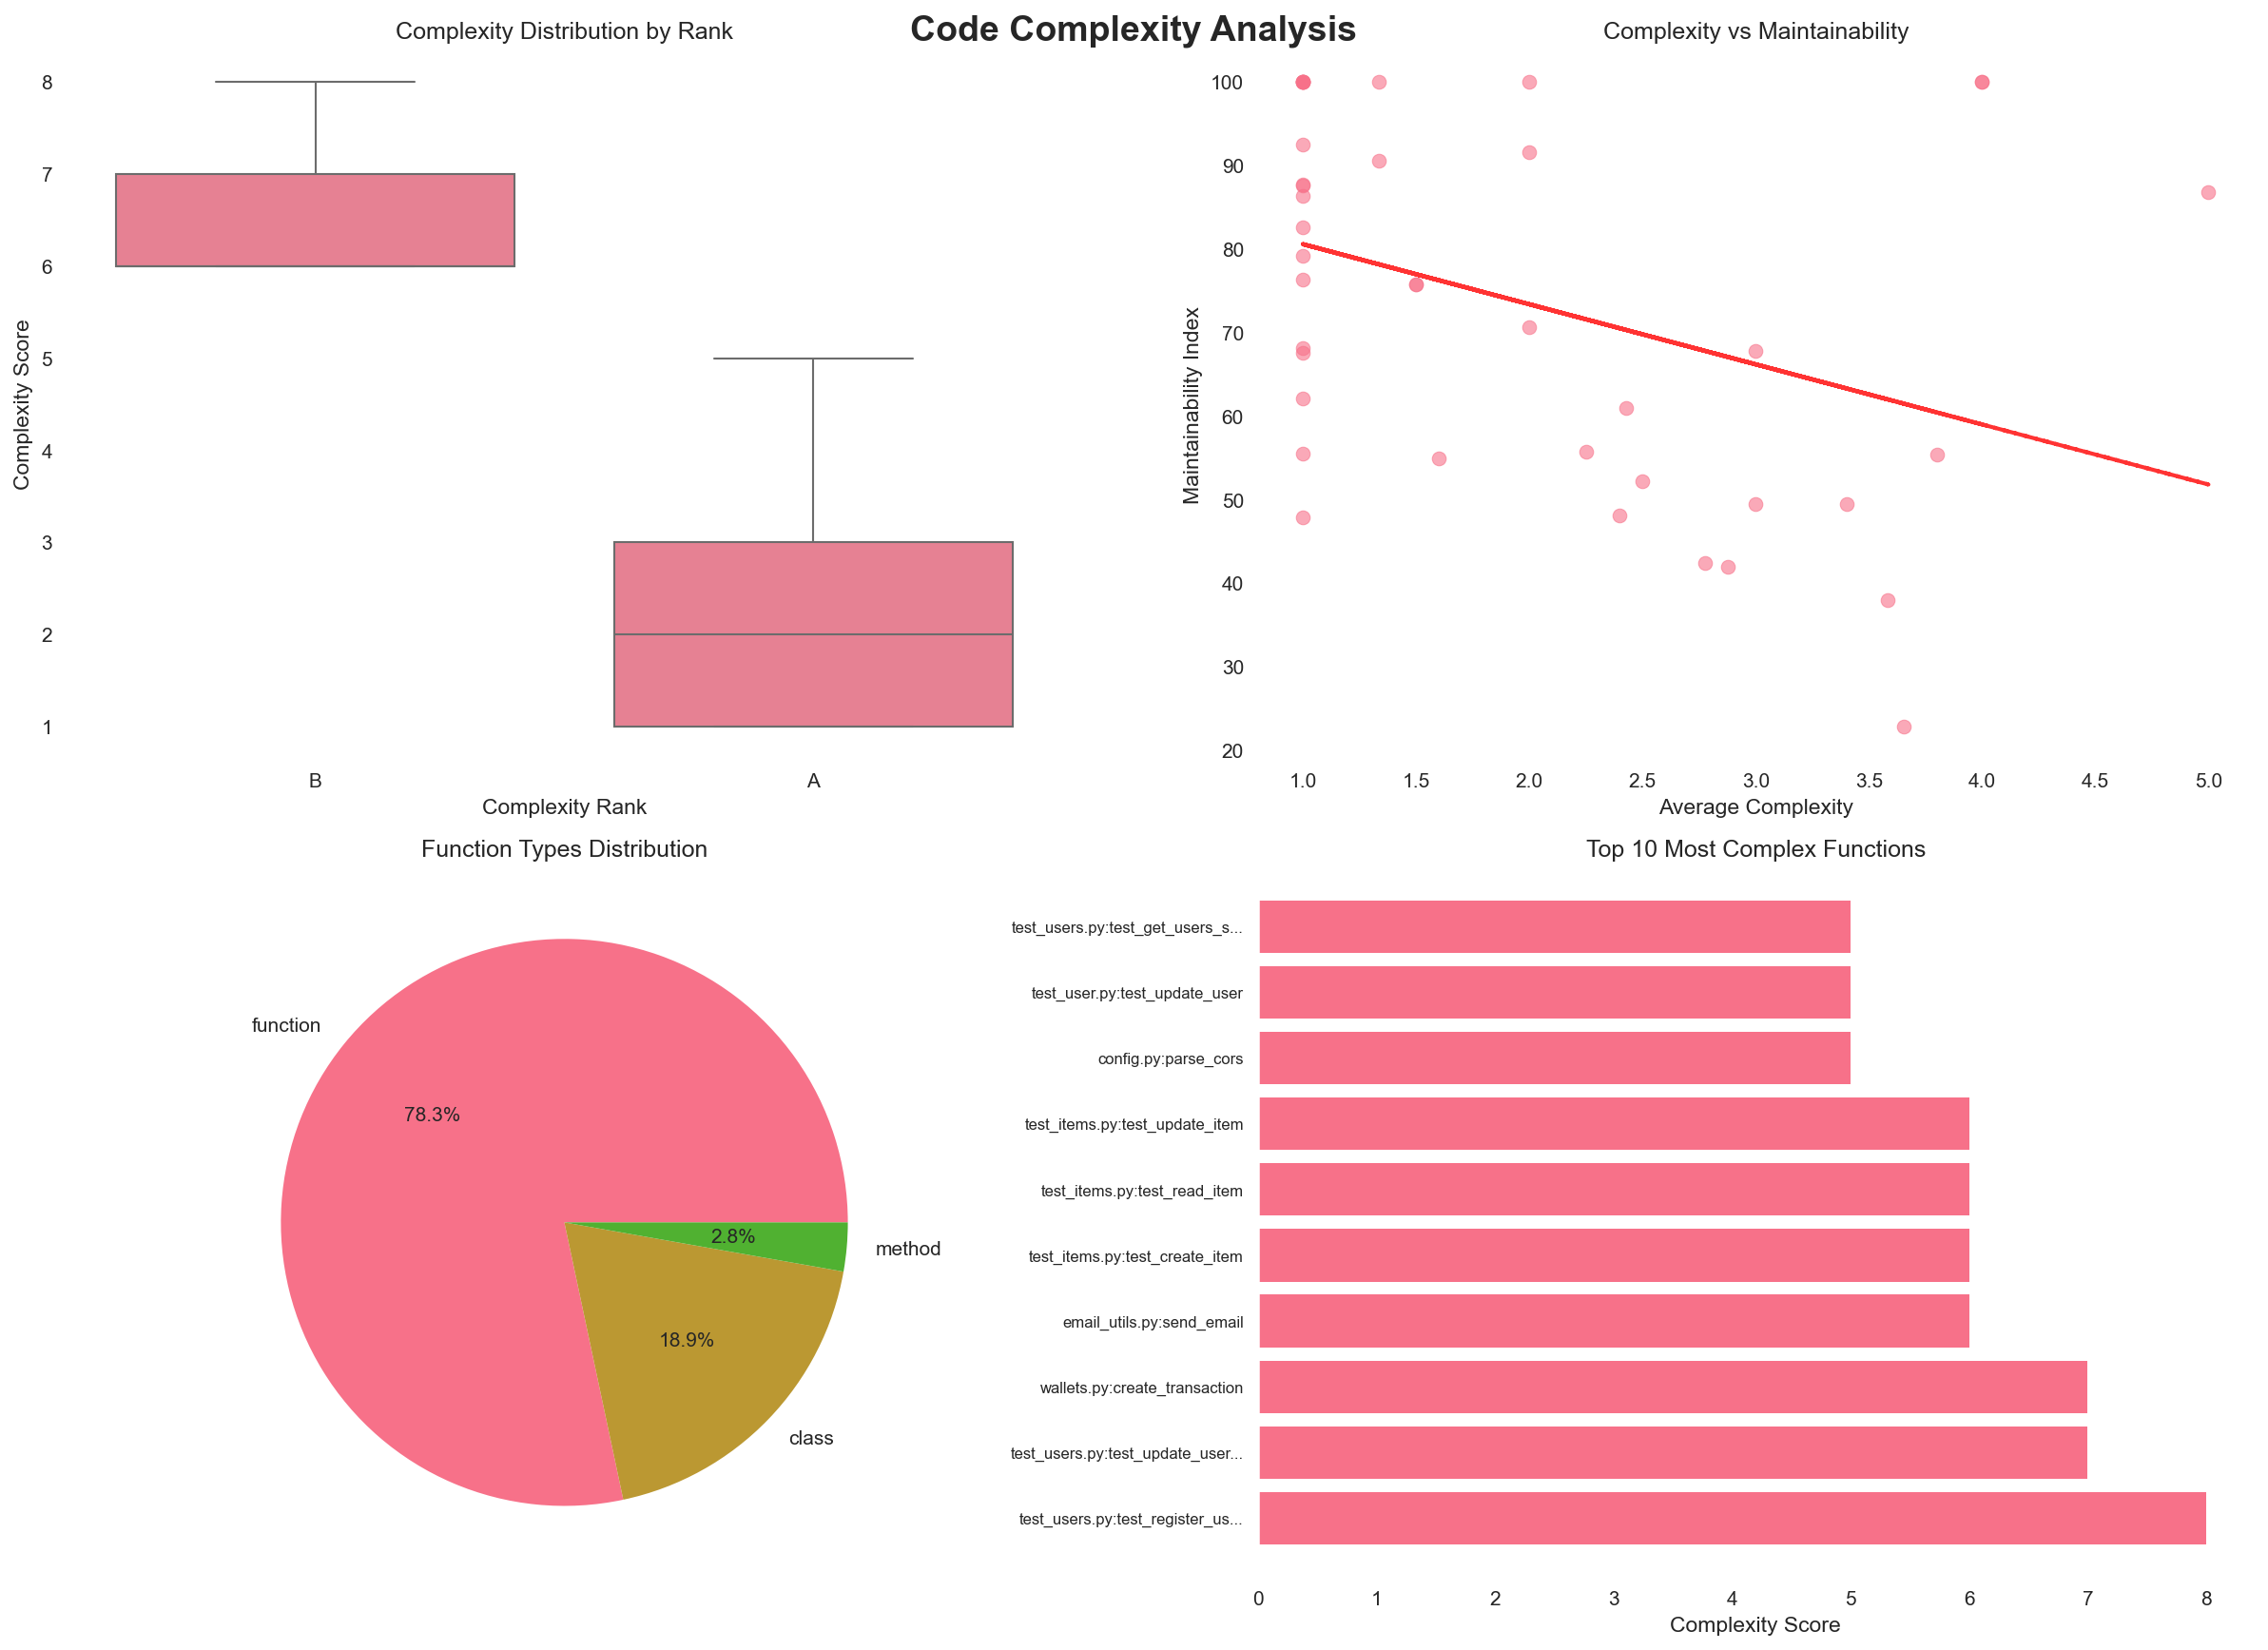

In [13]:
# Create detailed complexity analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=150)
fig.suptitle("Code Complexity Analysis", fontsize=18, fontweight="bold", y=0.96)

# Cyclomatic Complexity Box Plot by Rank
if not radon_cc_results.empty:
    sns.boxplot(data=radon_cc_results, x="rank", y="complexity", ax=axes[0, 0])
    axes[0, 0].set_title("Complexity Distribution by Rank")
    axes[0, 0].set_xlabel("Complexity Rank")
    axes[0, 0].set_ylabel("Complexity Score")
else:
    axes[0, 0].text(
        0.5,
        0.5,
        "No complexity data",
        ha="center",
        va="center",
        transform=axes[0, 0].transAxes,
    )
    axes[0, 0].set_title("Complexity Distribution by Rank")

# Maintainability Index vs Complexity (if both available)
if not radon_cc_results.empty and not radon_mi_results.empty:
    # Merge CC and MI data by file
    cc_by_file = radon_cc_results.groupby("file")["complexity"].mean().reset_index()
    mi_by_file = radon_mi_results[["file", "mi_score"]].copy()

    merged = pd.merge(cc_by_file, mi_by_file, on="file", how="inner")

    if not merged.empty:
        axes[0, 1].scatter(merged["complexity"], merged["mi_score"], alpha=0.6)
        axes[0, 1].set_xlabel("Average Complexity")
        axes[0, 1].set_ylabel("Maintainability Index")
        axes[0, 1].set_title("Complexity vs Maintainability")

        # Add trend line
        z = np.polyfit(merged["complexity"], merged["mi_score"], 1)
        p = np.poly1d(z)
        axes[0, 1].plot(merged["complexity"], p(merged["complexity"]), "r--", alpha=0.8)
    else:
        axes[0, 1].text(
            0.5,
            0.5,
            "No matching files",
            ha="center",
            va="center",
            transform=axes[0, 1].transAxes,
        )
        axes[0, 1].set_title("Complexity vs Maintainability")
else:
    axes[0, 1].text(
        0.5,
        0.5,
        "Insufficient data",
        ha="center",
        va="center",
        transform=axes[0, 1].transAxes,
    )
    axes[0, 1].set_title("Complexity vs Maintainability")

# Function type distribution in complexity
if not radon_cc_results.empty:
    func_type_counts = radon_cc_results["type"].value_counts()
    axes[1, 0].pie(
        func_type_counts.values, labels=func_type_counts.index, autopct="%1.1f%%"
    )
    axes[1, 0].set_title("Function Types Distribution")
else:
    axes[1, 0].text(
        0.5,
        0.5,
        "No function data",
        ha="center",
        va="center",
        transform=axes[1, 0].transAxes,
    )
    axes[1, 0].set_title("Function Types Distribution")

# Top 10 most complex functions
if not radon_cc_results.empty:
    top_complex = radon_cc_results.nlargest(10, "complexity")

    # Create shorter labels for function names
    labels = [
        f"{Path(row['file']).name}:{row['function']}"
        for _, row in top_complex.iterrows()
    ]
    short_labels = [
        label[:30] + "..." if len(label) > 30 else label for label in labels
    ]

    y_pos = range(len(top_complex))
    axes[1, 1].barh(y_pos, top_complex["complexity"])
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels(short_labels, fontsize=8)
    axes[1, 1].set_xlabel("Complexity Score")
    axes[1, 1].set_title("Top 10 Most Complex Functions")
else:
    axes[1, 1].text(
        0.5,
        0.5,
        "No function data",
        ha="center",
        va="center",
        transform=axes[1, 1].transAxes,
    )
    axes[1, 1].set_title("Top 10 Most Complex Functions")

plt.tight_layout()
plt.show()

## Create Summary Dashboard

In [14]:
# Create a comprehensive summary
print("\n" + "=" * 80)
print("CODE QUALITY ANALYSIS SUMMARY")
print("=" * 80)
print(
    "Note: Radon cyclomatic complexity and maintainability entries with rank 'A' are treated as non-issues and excluded from issue counts while still used in distribution plots."
)

# Overall statistics
total_issues = sum(summary_stats[tool]["total_issues"] for tool in summary_stats)
files_with_any = [
    summary_stats[tool]["files_analyzed"]
    for tool in summary_stats
    if summary_stats[tool]["files_analyzed"] > 0
]
total_files = max(files_with_any) if files_with_any else 0

print("\n📊 OVERALL METRICS:")
print(f"   Total Issues Found (excluding Radon A ranks): {total_issues}")
print(f"   Files Analyzed (max across tools): {total_files}")
print(
    f"   Average Issues per File: {total_issues / total_files:.2f}"
    if total_files > 0
    else "   Average Issues per File: N/A"
)

# Tool-specific summaries
print("\n🔍 TOOL BREAKDOWN:")
for tool, stats in summary_stats.items():
    print(
        f"   {tool.upper()}: {stats['total_issues']} issues across {stats['files_analyzed']} files"
    )

# Quality insights
print("\n💡 QUALITY INSIGHTS:")

if not bandit_results.empty:
    high_severity = len(bandit_results[bandit_results["severity"] == "HIGH"])
    print(f"   🚨 Security: {high_severity} high-severity security issues found")

if not radon_cc_results.empty:
    avg_complexity = radon_cc_results["complexity"].mean()
    high_complexity = len(radon_cc_results[radon_cc_results["complexity"] > 10])
    print(
        f"   🔄 Complexity: Average CC (all ranks) = {avg_complexity:.2f}, {high_complexity} functions with CC > 10"
    )

if not radon_mi_results.empty:
    avg_mi = radon_mi_results["mi_score"].mean()
    low_mi = len(radon_mi_results[radon_mi_results["mi_score"] < 20])
    print(
        f"   🛠️  Maintainability: Average MI (all ranks) = {avg_mi:.2f}, {low_mi} files with MI < 20 (needs attention)"
    )

if not vulture_results.empty:
    avg_confidence = vulture_results["confidence"].mean()
    high_confidence_dead = len(vulture_results[vulture_results["confidence"] >= 80])
    print(
        f"   💀 Dead Code: {len(vulture_results)} potential dead code items, {high_confidence_dead} with ≥80% confidence"
    )

# Recommendations
print("\n📋 RECOMMENDATIONS:")

if total_issues == 0:
    print(
        "   ✅ Excellent! No issues found by any tool (after excluding A rank Radon entries)."
    )
else:
    print(f"   1. Address {total_issues} total issues found across all tools")

    if not bandit_results.empty:
        print(f"   2. Security: Review and fix {len(bandit_results)} security issues")

    if not vulture_results.empty:
        high_conf_vulture = len(vulture_results[vulture_results["confidence"] >= 80])
        print(
            f"   3. Dead Code: Remove {high_conf_vulture} high-confidence dead code items"
        )

    if not radon_cc_results.empty and radon_cc_results["complexity"].max() > 15:
        print("   4. Complexity: Refactor functions with complexity > 15")

    if not radon_mi_results.empty and radon_mi_results["mi_score"].min() < 10:
        print("   5. Maintainability: Improve files with MI < 10")

    if not ruff_results.empty:
        top_ruff_rule = ruff_results["rule_code"].value_counts().index[0]
        print(f"   6. Style: Focus on fixing {top_ruff_rule} rule violations first")

print("\n" + "=" * 80)

# Create final summary table
summary_table = pd.DataFrame(
    {
        "Tool": list(summary_stats.keys()),
        "Total Issues (A excl)": [
            summary_stats[tool]["total_issues"] for tool in summary_stats
        ],
        "Files Analyzed": [
            summary_stats[tool]["files_analyzed"] for tool in summary_stats
        ],
        "Issues per File": [
            summary_stats[tool]["total_issues"]
            / max(summary_stats[tool]["files_analyzed"], 1)
            for tool in summary_stats
        ],
    }
)

print("\nFINAL SUMMARY TABLE:")
print(summary_table.to_string(index=False))

# Save results to CSV for further analysis
summary_table.to_csv("code_quality_summary.csv", index=False)
print("\n💾 Results saved to 'code_quality_summary.csv'")

if not combined_issues.empty:
    combined_issues.to_csv("detailed_issues.csv", index=False)
    print("💾 Detailed issues saved to 'detailed_issues.csv'")


CODE QUALITY ANALYSIS SUMMARY
Note: Radon cyclomatic complexity and maintainability entries with rank 'A' are treated as non-issues and excluded from issue counts while still used in distribution plots.

📊 OVERALL METRICS:
   Total Issues Found (excluding Radon A ranks): 48
   Files Analyzed (max across tools): 4
   Average Issues per File: 12.00

🔍 TOOL BREAKDOWN:
   BANDIT: 2 issues across 2 files
   RUFF: 8 issues across 2 files
   MYPY: 7 issues across 2 files
   RADON_CC: 7 issues across 4 files
   RADON_MI: 0 issues across 0 files
   FLAKE8_WPS: 16 issues across 2 files
   VULTURE: 8 issues across 3 files

💡 QUALITY INSIGHTS:
   🚨 Security: 0 high-severity security issues found
   🔄 Complexity: Average CC (all ranks) = 2.27, 0 functions with CC > 10
   🛠️  Maintainability: Average MI (all ranks) = 80.63, 0 files with MI < 20 (needs attention)
   💀 Dead Code: 8 potential dead code items, 0 with ≥80% confidence

📋 RECOMMENDATIONS:
   1. Address 48 total issues found across all too

In [ ]:
# Export Radon data for comparison analysis
print("\n" + "🔄" * 3 + " EXPORTING RADON DATA FOR COMPARISON " + "🔄" * 3)

# Export Radon Cyclomatic Complexity data
if not radon_cc_results.empty:
    # Prepare complexity data in the expected format
    complexity_export = radon_cc_results[['file', 'function', 'line', 'complexity', 'rank', 'type']].copy()
    
    # Save to CSV
    complexity_file = "radon_complexity.csv"
    complexity_export.to_csv(complexity_file, index=False)
    
    print(f"✅ Exported Radon Complexity data: {complexity_file}")
    print(f"   📊 {len(complexity_export)} functions/methods exported")
    print(f"   📈 Average complexity: {complexity_export['complexity'].mean():.2f}")
    print(f"   🎯 Complexity range: {complexity_export['complexity'].min()} - {complexity_export['complexity'].max()}")
else:
    print("⚠️  No Radon complexity data available for export")

# Export Radon Maintainability Index data  
if not radon_mi_results.empty:
    # Prepare maintainability data in the expected format
    maintainability_export = radon_mi_results[['file', 'mi_score', 'mi_rank']].copy()
    
    # Save to CSV
    maintainability_file = "radon_maintainability.csv"
    maintainability_export.to_csv(maintainability_file, index=False)
    
    print(f"\n✅ Exported Radon Maintainability data: {maintainability_file}")
    print(f"   📊 {len(maintainability_export)} files exported")
    print(f"   📈 Average MI score: {maintainability_export['mi_score'].mean():.2f}")
    print(f"   🎯 MI score range: {maintainability_export['mi_score'].min():.1f} - {maintainability_export['mi_score'].max():.1f}")
else:
    print("⚠️  No Radon maintainability data available for export")

# Summary of all exported files
print(f"\n📁 EXPORTED FILES SUMMARY:")
exported_files = []

if Path("code_quality_summary.csv").exists():
    exported_files.append("code_quality_summary.csv")
    print(f"   ✅ code_quality_summary.csv")

if Path("detailed_issues.csv").exists():
    exported_files.append("detailed_issues.csv") 
    print(f"   ✅ detailed_issues.csv")

if Path("radon_complexity.csv").exists():
    exported_files.append("radon_complexity.csv")
    print(f"   ✅ radon_complexity.csv")
    
if Path("radon_maintainability.csv").exists():
    exported_files.append("radon_maintainability.csv")
    print(f"   ✅ radon_maintainability.csv")

print(f"\n🎯 Ready for comparison analysis!")
print(f"   Total files exported: {len(exported_files)}")
print(f"   🚀 Copy these CSV files to your implementation directory in:")
print(f"      code_quality_comparison/data/[your_implementation_name]/")
print(f"\n💡 Tip: Run the code_quality_comparison.ipynb notebook to compare multiple implementations!")